One idea that we ought to be able to leverage is to create a module (with an accompanying IR interface) that abstracts the Halide code target.  Doing this will hopefully simplify code-generation, as well as allow us to dump out "the Halide program" in a form that people unfamiliar with this tensor language can understand and appreciate.

In order to encapsulate some useful interface functionality we, will also put bindings with the NumPy library in this module.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../src/')
from adt import ADT
from adt import memo as ADTmemo
import numpy as np
import ctypes
from halide import halide_type_t, halide_buffer_t, halide_dimension_t
from halide import hw_expr_t, hw_var_t, hw_rdom_t, hw_func_t, hw_img_t, hw_param_t
from halide import C

# Halide IR

A Halide program is a sequence of statements (stages), each of which either defines or updates a given `func`.  All updates to a func must come immediately subsequent to the definition of that func.

At the start of the program, some number of `var` and `rdom` variables may be declared.

The overall program is called a "pipeline."  It has zero or more inputs supplied as `param`s (scalars) or `img`s (multi-dimensional arrays).  The `img` object is backed by a `halide_buffer_t`, which we will see can be supplied from a NumPy array.  The output is likewise backed by a `halide_buffer_t`.  In order to support multiple output buffers, we use a `pipeline` object to group those output `func`s.

The Halide primitive type system has `int`, `uint` and `float` with different bit-widths (e.g. 8, 16, 32, 64) and different vector widths (e.g. 1,2,3,4).  This too must be reflected in the IR.

In [2]:
binops = {
    "+":    True,
    "-":    True,
    "*":    True,
    "/":    True,
    "==":   True,
    "<":    True,
    ">":    True,
    "<=":   True,
    ">=":   True,
}

basetypes = {
    "f32":  True,
    "f64":  True,
}
for bw in ["8","16","32","64"]:
    basetypes["i"+bw] = True
    basetypes["u"+bw] = True

HIR = ADT("""
module HIR {
    pipeline   = Pipeline  ( var*   vars,
                             rdom*  rdoms,
                             func*  funcs,
                             param* params,
                             img*   imgs,
                             stmt*  stmts,
                             func*  outputs )

    var    = Var       ( string name )
    rdom   = RDom      ( string name, range* bounds )
    param  = Param     ( string name, type typ )
    img    = Img       ( string name, int ndim, type typ )
    func   = Func      ( string name )
           | ImgFunc   ( img img )
    
    expr   = Const     ( object v, type typ )
           | Evar      ( var v )
           | Erdom     ( rdom r )
           | Eparam    ( param p )
           | BinOp     ( op op, expr lhs, expr rhs )
           | Min       ( expr lhs, expr rhs )
           | Max       ( expr lhs, expr rhs )
           | Select    ( expr pred, expr lhs, expr rhs )
           | FAccess   ( func f, expr* args )
           | BigSum    ( rdom r, expr body )
    
    stmt   = PureDef   ( func f, var* args, expr rhs )
           | Update    ( func f, expr* args, expr rhs )
    
    range  = Range ( expr lo, expr hi )
    type   = Type  ( typbase base, int lanes )
}
""", {
    'op':         lambda x:  x in binops,
    'typbase':    lambda x:  x in basetypes,
})
ADTmemo(HIR,['Type'],{'typbase': lambda x: x})
f32, f64            = HIR.Type('f32',1), HIR.Type('f64',1)
u8,  u16, u32, u64  = (HIR.Type('u8',1),  HIR.Type('u16',1),
                       HIR.Type('u32',1), HIR.Type('u64',1))
i8,  i16, i32, i64  = (HIR.Type('i8',1),  HIR.Type('i16',1),
                       HIR.Type('i32',1), HIR.Type('i64',1))

## Input Short-hand

In order to make the IR easier to input in this notebook, let's create some shorthand.

In [3]:
def _lift_(obj):
    if isinstance(obj,HIR.expr):
        return obj
    if isinstance(obj,HIR.func):
        return obj
    elif isinstance(obj,HIR.Var):
        return HIR.Evar(obj)
    elif isinstance(obj,HIR.RDom):
        return HIR.Erdom(obj)
    elif isinstance(obj,HIR.Param):
        return HIR.Eparam(obj)
    elif isinstance(obj,HIR.Img):
        return HIR.ImgFunc(obj)
    elif type(obj) is int:
        return HIR.Const(obj,i32)
    elif type(obj) is float:
        return HIR.Const(obj,f64)
    else:
        raise TypeError("unrecognized object type")

def _Min(x,y):
    return HIR.Min(_lift_(x),_lift_(y))
def _Max(x,y):
    return HIR.Max(_lift_(x),_lift_(y))

def _expr_add_(lhs,rhs):
    return HIR.BinOp('+',_lift_(lhs),_lift_(rhs))
HIR.expr.__add__  = _expr_add_
HIR.expr.__radd__ = lambda r,l: _expr_add_(l,r)

def _expr_sub_(lhs,rhs):
    return HIR.BinOp('-',_lift_(lhs),_lift_(rhs))
HIR.expr.__sub__  = _expr_sub_
HIR.expr.__rsub__ = lambda r,l: _expr_sub_(l,r)

def _expr_mul_(lhs,rhs):
    return HIR.BinOp('*',_lift_(lhs),_lift_(rhs))
HIR.expr.__mul__  = _expr_mul_
HIR.expr.__rmul__ = lambda r,l: _expr_mul_(l,r)

def _expr_div_(lhs,rhs):
    return HIR.BinOp('/',_lift_(lhs),_lift_(rhs))
HIR.expr.__truediv__  = _expr_div_
HIR.expr.__rtruediv__ = lambda r,l: _expr_div_(l,r)

def _expr_lt_(lhs,rhs):
    return HIR.BinOp('<',_lift_(lhs),_lift_(rhs))
HIR.expr.__lt__  = _expr_lt_
HIR.expr.__rlt__ = lambda r,l: _expr_lt_(l,r)

def _expr_gt_(lhs,rhs):
    return HIR.BinOp('>',_lift_(lhs),_lift_(rhs))
HIR.expr.__gt__  = _expr_gt_
HIR.expr.__rgt__ = lambda r,l: _expr_gt_(l,r)

def _expr_le_(lhs,rhs):
    return HIR.BinOp('<=',_lift_(lhs),_lift_(rhs))
HIR.expr.__le__  = _expr_le_
HIR.expr.__rle__ = lambda r,l: _expr_le_(l,r)

def _expr_ge_(lhs,rhs):
    return HIR.BinOp('>=',_lift_(lhs),_lift_(rhs))
HIR.expr.__ge__  = _expr_ge_
HIR.expr.__rge__ = lambda r,l: _expr_ge_(l,r)

# expose arithmetic operators to un-lifted vars, rdoms, params
for t in [HIR.var,HIR.rdom,HIR.param]:
    for nm in ['__add__','__sub__','__mul__','__truediv__',
               '__radd__','__rsub__','__rmul__','__rtruediv__',
               '__lt__','__gt__','__le__','__ge__',
               '__rlt__','__rgt__','__rle__','__rge__']:
        setattr(t,nm,getattr(HIR.expr,nm))

def _func_getitem_(f,keys):
    if not type(keys) is tuple: keys = (keys,)
    keys    = [ _lift_(k) for k in keys ]
    f       = _lift_(f)
    return HIR.FAccess(f,keys)
HIR.func.__getitem__ = _func_getitem_
HIR.img.__getitem__  = _func_getitem_

### Example Halide Programs in the IR

Let's try to write:
*   a 3x3 blur kernel
*   a Laplacian-based energy sum of squares
*   an image gradient output as two separate images for dx and dy

In [4]:
def gen_blur():
    lift        = _lift_
    Min, Max    = _Min, _Max
    in_img      = HIR.Img('in_img', 2, f64)
    w, h        = HIR.Param('w',i32), HIR.Param('h',i32)
    clamp       = lambda x,lo,hi: Max( lo, Min( hi, x ) )
    
    x, y        = HIR.Var('x'), HIR.Var('y')
    f           = HIR.Func('f')
    blur_x      = HIR.Func('blur_x')
    blur_y      = HIR.Func('blur_y')
    
    stmts       = [
        HIR.PureDef( f, [x,y], in_img[clamp(x,0,w-1),clamp(y,0,h-1)]),
        HIR.PureDef( blur_x, [x,y], (f[x-1,y] + 2.0*f[x,y] + f[x+1,y])/4.0 ),
        HIR.PureDef( blur_y, [x,y], (blur_x[x,y-1] + 2.0*blur_x[x,y] + blur_x[x,y+1])/4.0 ),
    ]
    
    pipeline     = HIR.Pipeline(
                     vars    = [x,y],
                     rdoms   = [],
                     funcs   = [f,blur_x,blur_y],
                     params  = [w,h],
                     imgs    = [in_img],
                     stmts   = stmts,
                     outputs = [blur_y])
    return pipeline
blurpipe = gen_blur()

def gen_laplacian():
    lift        = _lift_
    Min, Max    = _Min, _Max
    f           = HIR.Img('f', 2, f64)
    w, h        = HIR.Param('w',i32), HIR.Param('h',i32)
    
    x           = HIR.RDom('x', [HIR.Range(lift(0),lift(w))])
    y           = HIR.RDom('y', [HIR.Range(lift(0),lift(h))])
    result      = HIR.Func('result')
    dx, dy      = HIR.Func('dx'), HIR.Func('dy')
    i, j        = HIR.Var('i'), HIR.Var('j')
    
    Eq          = lambda x,y: HIR.BinOp('==',lift(x),lift(y))
    body        = ( HIR.Select( Eq(x,w-1), lift(0.0), dx[x,y]*dx[x,y] ) +
                    HIR.Select( Eq(y,h-1), lift(0.0), dy[x,y]*dy[x,y] ) )
    
    stmts       = [
        HIR.PureDef(dx, [i,j], f[Min(i+1,w-1),j] - f[i,j]),
        HIR.PureDef(dy, [i,j], f[i,Min(j+1,h-1)] - f[i,j]),
        HIR.PureDef(result, [i], lift(0.0)),
        HIR.Update (result, [lift(0)], HIR.BigSum(x, HIR.BigSum(y, body))),
    ]
    
    pipeline     = HIR.Pipeline(
                     vars    = [i,j],
                     rdoms   = [x,y],
                     funcs   = [result,dx,dy],
                     params  = [w,h],
                     imgs    = [f],
                     stmts   = stmts,
                     outputs = [result])
    return pipeline
laplacepipe = gen_laplacian()

def gen_grad():
    lift        = _lift_
    f           = HIR.Img('f', 2, f64)
    
    result      = HIR.Func('result')
    dx, dy      = HIR.Func('dx'), HIR.Func('dy')
    i, j        = HIR.Var('i'), HIR.Var('j')
    
    stmts       = [
        HIR.PureDef(dx, [i,j], f[i+1,j] - f[i,j]),
        HIR.PureDef(dy, [i,j], f[i,j+1] - f[i,j]),
    ]
    
    pipeline     = HIR.Pipeline(
                     vars    = [i,j],
                     rdoms   = [],
                     funcs   = [dx,dy],
                     params  = [],
                     imgs    = [f],
                     stmts   = stmts,
                     outputs = [dx,dy])
    return pipeline
gradpipe = gen_grad()

## Output Format

We can read these pipeline definitions more easily if we present them in a structured output format.



In [5]:
def _HIR_type_str_rep(t):
    if t.lanes > 1: return f"{t.base}v{t.lanes}"
    else:           return t.base
HIR.type.__str__    = _HIR_type_str_rep
del _HIR_type_str_rep

def _HIR_var_str_rep(v):
    return v.name
HIR.var.__str__     = _HIR_var_str_rep
del _HIR_var_str_rep

def _HIR_rdom_str_rep(r):
    bds = ']['.join([ f"{rg.lo},{rg.hi}" for rg in r.bounds ])
    return f"{r.name}[{bds}]"
HIR.rdom.__str__    = _HIR_rdom_str_rep
del _HIR_rdom_str_rep

def _HIR_param_str_rep(p):
    return f"{p.name} : {p.typ}"
HIR.param.__str__   = _HIR_param_str_rep
del _HIR_param_str_rep

def _HIR_img_str_rep(i):
    return f"{i.name}({i.ndim}) : {i.typ}"
HIR.img.__str__     = _HIR_img_str_rep
del _HIR_img_str_rep

def _HIR_func_str_rep(f):
    if   type(f) is HIR.Func:    return f.name
    elif type(f) is HIR.ImgFunc: return f.img.name
HIR.func.__str__    = _HIR_func_str_rep
del _HIR_func_str_rep

_HIR_op_prec = {
    "+" : 30,
    "-" : 30,
    "*" : 40,
    "/" : 40,
    "<" : 20,
    ">" : 20,
    "<=" : 20,
    ">=" : 20,
    "==" : 10,
}
def _HIR_expr_str_rep(e,prec=0):
    eclass = type(e)
    s      = "ERROR"
    if   eclass is HIR.Evar:   s = e.v.name
    elif eclass is HIR.Erdom:  s = e.r.name
    elif eclass is HIR.Eparam: s = e.p.name
    elif eclass is HIR.Const:
        if e.typ is i32 or e.typ is f64:
            s = str(e.v)
        else:
            s = f"({e.v}:{e.typ})"
    elif eclass is HIR.BinOp:
        op_prec = _HIR_op_prec[e.op]
        s = (f"{_HIR_expr_str_rep(e.lhs,op_prec)} {e.op} "
             f"{_HIR_expr_str_rep(e.rhs,op_prec+1)}")
        if prec > op_prec: s = f"({s})"
    elif eclass is HIR.Min or eclass is HIR.Max:
        fname = "Min" if eclass is HIR.Min else "Max"
        s = f"{fname}({e.lhs},{e.rhs})"
    elif eclass is HIR.Select:
        s = f"select({e.pred},{e.lhs},{e.rhs})"
    elif eclass is HIR.FAccess:
        args = ','.join([ str(a) for a in e.args ])
        s = f"{e.f}({args})"
    elif eclass is HIR.BigSum:
        s = f"sum({e.r.name},{e.body})"
    return s
HIR.expr.__str__    = _HIR_expr_str_rep
_HIR_expr_str_rep

def _HIR_stmt_str_rep(s):
    args = ','.join([ str(a) for a in s.args ])
    return f"{s.f}({args}) = {s.rhs}"
HIR.stmt.__str__    = _HIR_stmt_str_rep
del _HIR_stmt_str_rep

def _HIR_pipe_str_rep(p):
    vs    = '\n        '.join([ str(v) for v in p.vars ])
    rs    = '\n        '.join([ str(r) for r in p.rdoms ])
    fs    = '\n        '.join([ str(f) for f in p.funcs ])
    ps    = '\n        '.join([ str(p) for p in p.params ])
    imgs  = '\n        '.join([ str(i) for i in p.imgs ])
    stmts = '\n        '.join([ str(s) for s in p.stmts ])
    outs  = '\n        '.join([ str(o) for o in p.outputs ])
    
    s = (f"Var     {vs}\n"
         f"RDom    {rs}\n"
         f"Func    {fs}\n"
         f"Param   {ps}\n"
         f"Img     {imgs}\n"
         f"Stmt    {stmts}\n"
         f"Out     {outs}")
    return s
HIR.pipeline.__str__ = _HIR_pipe_str_rep
del _HIR_pipe_str_rep

### Printing Out the Example Programs

In [6]:
print("Blur Pipeline\n----------")
print(blurpipe)
print("\n\nLaplacian Energy Pipeline\n----------")
print(laplacepipe)
print("\n\nGradient Pipeline\n----------")
print(gradpipe)

Blur Pipeline
----------
Var     x
        y
RDom    
Func    f
        blur_x
        blur_y
Param   w : i32
        h : i32
Img     in_img(2) : f64
Stmt    f(x,y) = in_img(Max(0,Min(w - 1,x)),Max(0,Min(h - 1,y)))
        blur_x(x,y) = (f(x - 1,y) + 2.0 * f(x,y) + f(x + 1,y)) / 4.0
        blur_y(x,y) = (blur_x(x,y - 1) + 2.0 * blur_x(x,y) + blur_x(x,y + 1)) / 4.0
Out     blur_y


Laplacian Energy Pipeline
----------
Var     i
        j
RDom    x[0,w]
        y[0,h]
Func    result
        dx
        dy
Param   w : i32
        h : i32
Img     f(2) : f64
Stmt    dx(i,j) = f(Min(i + 1,w - 1),j) - f(i,j)
        dy(i,j) = f(i,Min(j + 1,h - 1)) - f(i,j)
        result(i) = 0.0
        result(0) = sum(x,sum(y,select(x == w - 1,0.0,dx(x,y) * dx(x,y)) + select(y == h - 1,0.0,dy(x,y) * dy(x,y))))
Out     result


Gradient Pipeline
----------
Var     i
        j
RDom    
Func    dx
        dy
Param   
Img     f(2) : f64
Stmt    dx(i,j) = f(i + 1,j) - f(i,j)
        dy(i,j) = f(i,j + 1) - f(i,j)

## Executing a Pipeline

We would like some way to execute a pipeline.  In general, we may want other ways to execute or compile a pipeline, but for the time being, we will rely on the following ideas.

Every pipeline has some number of `Var`, `RDom`, and `Func` variables.  However, by definition these must all be internal to the pipeline.  Specifically `Param` and `Img` variables represent external inputs.  And then the output funcs represent the returned values.

Therefore we can define a Halide pipeline's compilation to a function as supplying and receiving these specific parameters and buffers.  The multi-dimensional buffers will be specified as numpy arrays.

To begin, we must lower all of the pipeline IR nodes into Halide objects, which I will call "compilation" here even though the Halide compiler has not properly been invoked yet.

In [7]:
def _HIR_Type_struct(typ):
    if hasattr(typ, '_cached_struct'): return typ._cached_struct
    if   typ.base[0] == 'f': flag = C.type_float
    elif typ.base[0] == 'u': flag = C.type_uint
    elif typ.base[0] == 'i': flag = C.type_int
    bits = int(typ.base[1:])
    typ._cached_struct = halide_type_t(flag,bits,typ.lanes)
    return typ._cached_struct
HIR.Type.struct = _HIR_Type_struct
del _HIR_Type_struct

class _HIR_Compilation:
    def __init__(self, pipe):
        self._pipe   = pipe
        self._vars   = {
            v : C.hwrap_new_var(bytes(v.name,'utf-8'))
            for v in pipe.vars }
        self._params = {
            p : C.hwrap_new_param(bytes(p.name,'utf-8'),
                                  p.typ.struct())
            for p in pipe.params }
        self._imgs   = {
            i : C.hwrap_new_img(bytes(i.name,'utf-8'),
                                i.ndim, i.typ.struct())
            for i in pipe.imgs }
        self._funcs  = {
            f : C.hwrap_new_func(bytes(f.name,'utf-8'))
            for f in pipe.funcs }
        self._rdoms  = {}
        self._exprs  = {}
        self._stmts  = {
            s : self.get_stmt(s)
            for s in pipe.stmts }
        
    
    def get_func(self,f):
        if f in self._funcs: return self._funcs[f]
        else:
            assert type(f) is HIR.ImgFunc
            f_img   = C.hwrap_img_to_func(self._imgs[f.img])
            self._funcs[f] = f_img
            return f_img
    
    def get_rdom(self,r):
        if r in self._rdoms: return self._rdoms[r]
        n_bd    = len(r.bounds)
        bds     = []
        for rng in r.bounds:
            bds.append( self.get_expr(rng.lo) )
            bds.append( self.get_expr(rng.hi) )
        c_bds   = ((n_bd * 2) * hw_expr_t)(*bds)
        rd = C.hwrap_new_rdom(bytes(r.name,'utf-8'),
                              n_bd, c_bds)
        self._rdoms[r] = rd
        return rd
    
    def get_expr(self,e):
        if e in self._exprs: return self._exprs[e]
        ee      = None
        eclass  = type(e)
        if   eclass is HIR.Const:
            assert e.typ.lanes == 1
            ee  = getattr(C, f"hwrap_{e.typ.base}_to_expr")(e.v)
        elif eclass is HIR.Evar:
            ee  = C.hwrap_var_to_expr(self._vars[e.v])
        elif eclass is HIR.Erdom:
            rr  = self.get_rdom(e.r)
            ee  = C.hwrap_rdom_to_expr(rr)
        elif eclass is HIR.Eparam:
            ee  = C.hwrap_param_to_expr(self._params[e.p])
        elif eclass is HIR.BinOp:
            if   e.op == "+":   op_f = C.hwrap_add
            elif e.op == "-":   op_f = C.hwrap_sub
            elif e.op == "*":   op_f = C.hwrap_mul
            elif e.op == "/":   op_f = C.hwrap_div
            elif e.op == "==":  op_f = C.hwrap_eq
            elif e.op == "<":   op_f = C.hwrap_lt
            elif e.op == ">":   op_f = C.hwrap_gt
            elif e.op == "<=":  op_f = C.hwrap_le
            elif e.op == ">=":  op_f = C.hwrap_ge
            else: assert False, f"unrecognized operator: {e.op}"
            ee  = op_f(self.get_expr(e.lhs), self.get_expr(e.rhs))
        elif eclass is HIR.Min:
            ee  = C.hwrap_min(self.get_expr(e.lhs), self.get_expr(e.rhs))
        elif eclass is HIR.Max:
            ee  = C.hwrap_max(self.get_expr(e.lhs), self.get_expr(e.rhs))
        elif eclass is HIR.Select:
            ee  = C.hwrap_select(self.get_expr(e.pred),
                                 self.get_expr(e.lhs),
                                 self.get_expr(e.rhs))
        elif eclass is HIR.FAccess:
            args    = [ self.get_expr(a) for a in e.args ]
            c_args  = (len(args)*hw_expr_t)(*args)
            ee  = C.hwrap_access_func(self.get_func(e.f),
                                      len(args),c_args)
        elif eclass is HIR.BigSum:
            r   = self.get_rdom(e.r)
            ee  = C.hwrap_big_sum(r, self.get_expr(e.body))
        self._exprs[e]  = ee
        return ee
    
    def get_stmt(self, s):
        f       = self.get_func(s.f)
        rhs     = self.get_expr(s.rhs)
        if type(s) is HIR.PureDef:
            args    = [ self._vars[v] for v in s.args ]
            c_args  = (len(args)*hw_var_t)(*args)
            return C.hwrap_pure_def(f, len(args), c_args, rhs)
        elif type(s) is HIR.Update:
            args    = [ self.get_expr(e) for e in s.args ]
            c_args  = (len(args)*hw_expr_t)(*args)
            return C.hwrap_update(f, len(args), c_args, rhs)
        

### NumPy Bindings

Let's go ahead and include these buffer conversions here.  We'll need them to actually execute a pipeline.

In [8]:
def _ndarray_to_halide_buf(a):
    def typ_convert(dt):
        t = dt.type
        # remapping to prevent some pointless errors
        if t is float:
            t = np.float64 if (sys.float_info.max_exp == 1024) else np.float32
        if t is int:   t = np.int32
        # main case switch
        if   t is np.int8:    return halide_type_t(C.type_int,8,1)
        elif t is np.int16:   return halide_type_t(C.type_int,16,1)
        elif t is np.int32:   return halide_type_t(C.type_int,32,1)
        elif t is np.int64:   return halide_type_t(C.type_int,64,1)
        elif t is np.uint8:   return halide_type_t(C.type_uint,8,1)
        elif t is np.uint16:  return halide_type_t(C.type_uint,16,1)
        elif t is np.uint32:  return halide_type_t(C.type_uint,32,1)
        elif t is np.uint64:  return halide_type_t(C.type_uint,64,1)
        elif t is np.float32: return halide_type_t(C.type_float,32,1)
        elif t is np.float64: return halide_type_t(C.type_float,64,1)
        else:
            raise TypeError(f"unexpected type {t}")
    
    buf  = halide_buffer_t()
    buf.device              = 0
    buf.device_interface    = None
    buf.host                = a.ctypes.data_as(ctypes.POINTER(ctypes.c_ubyte))
    buf.flags               = 0
    buf.type                = typ_convert(a.dtype)
    buf.dimensions          = a.ndim
    buf.dim                 = (halide_dimension_t * a.ndim)()
    # now loop through and sort out each dimension
    for k in range(0,a.ndim):
        s = int(a.strides[k] / a.itemsize)
        assert a.strides[k] % a.itemsize == 0
        buf.dim[k] = halide_dimension_t(0,a.shape[k],s,0)
    buf.padding             = None
    
    return buf


Testing that this works.

In [9]:
Av = np.array([[5.,2.,0.],[2.2,0.,4.5],[0.,6.1,3.3]], order='F')
Ahv = _ndarray_to_halide_buf(Av)
Ahv

### Execution

In order to invoke Halide's auto-tuner we need to have estimated values for parameters and input images.  However, we don't have sufficient data to do that until we have at least one call to the Halide function.  Therefore, we must have a special JIT function to apply these estimates on the first invocation

In [10]:
def _HIR_Type_ctype(typ):
    if hasattr(typ, '_cached_ctype'): return typ._cached_ctype
    if   typ.base == 'f32': ct = ctypes.c_float
    elif typ.base == 'f64': ct = ctypes.c_double
    elif typ.base == 'u8':  ct = ctypes.c_uint8
    elif typ.base == 'u16': ct = ctypes.c_uint16
    elif typ.base == 'u32': ct = ctypes.c_uint32
    elif typ.base == 'u64': ct = ctypes.c_uint64
    elif typ.base == 'i8':  ct = ctypes.c_int8
    elif typ.base == 'i16': ct = ctypes.c_int16
    elif typ.base == 'i32': ct = ctypes.c_int32
    elif typ.base == 'i64': ct = ctypes.c_int64
    typ._cached_ctype = ct
    return typ._cached_ctype
HIR.Type.ctype = _HIR_Type_ctype
del _HIR_Type_ctype

class _HIR_JIT_Execution(_HIR_Compilation):
    def __init__(self, pipe):
        super().__init__(pipe)
    
    def _check_args(self, params, imgs, outputs):
        if type(params) != list: raise TypeError("expected list of 'params'")
        if type(imgs)   != list: raise TypeError("expected list of 'imgs'")
        if type(outputs)!= list: raise TypeError("expected list of 'outputs'")
        n_p = len(self._pipe.params)
        n_i = len(self._pipe.imgs)
        n_o = len(self._pipe.outputs)
        if len(params)  != n_p: raise TypeError(f"expected list of {n_p} 'params'")
        if len(imgs)    != n_i: raise TypeError(f"expected list of {n_i} 'imgs'")
        if len(outputs) != n_o: raise TypeError(f"expected list of {n_o} 'outputs'")
    
    def _set_params(self, params):
        for k,val in enumerate(params):
            p_IR    = self._pipe.params[k]
            p_obj   = self._params[p_IR]
            val_ref = ctypes.byref(p_IR.typ.ctype()(val))
            C.hwrap_set_param(p_obj,val_ref)
        
    def _jit_compile(self, params, imgs, outputs):
        if hasattr(self,'_pipeline_obj'): return
        i32 = C.hwrap_i32_to_expr
        
        self._set_params(params)
        
        # estimate input bounds
        for k,np_arr in enumerate(imgs):
            img_IR  = self._pipe.imgs[k]
            img_obj = self._imgs[img_IR]
            for d_i,d_N in enumerate(np_arr.shape):
                C.hwrap_set_img_bound_estimate(img_obj,d_i,i32(0),i32(d_N))
                
        # estimate output bounds
        out_fs  = []
        for k,np_arr in enumerate(outputs):
            out_IR  = self._pipe.outputs[k]
            out_obj = self._funcs[out_IR]
            out_fs.append(out_obj)
            for d_i,d_N in enumerate(np_arr.shape):
                C.hwrap_set_func_bound_estimate(out_obj,d_i,i32(0),i32(d_N))
        
        n_out   = len(outputs)
        c_fs    = (n_out * hw_func_t)(*out_fs)
        self._pipeline_obj = C.hwrap_new_pipeline(n_out,c_fs)
        C.hwrap_autoschedule_pipeline(self._pipeline_obj)
        
    def _exec(self, params, imgs, outputs):
        self._check_args(params,imgs,outputs)
        self._jit_compile(params,imgs,outputs)
        
        # bind the arguments
        self._set_params(params)
        
        # bind input buffers
        for k,np_arr in enumerate(imgs):
            h_buf   = _ndarray_to_halide_buf(np_arr)
            img_obj = self._imgs[self._pipe.imgs[k]]
            C.hwrap_set_img(img_obj, ctypes.byref(h_buf))
        
        # bind output buffers and Execute!
        outs    = [ _ndarray_to_halide_buf(arr) for arr in outputs ]
        c_outs  = (len(outs)*halide_buffer_t)(*outs)
        C.hwrap_realize_pipeline(self._pipeline_obj, len(outs),c_outs)


In order to make execution easier to invoke on a pipeline, we can augment the Pipeline object with functions directly.

In [11]:
def _HIR_Pipeline_signature(self):
    ps    = '\n        '.join([ str(p) for p in self.params ])
    imgs  = '\n        '.join([ str(i) for i in self.imgs ])
    outs  = '\n        '.join([ str(o) for o in self.outputs ])
    
    s = (f"Param   {ps}\n"
         f"Img     {imgs}\n"
         f"Out     {outs}")
    return s
HIR.Pipeline.signature = _HIR_Pipeline_signature
del _HIR_Pipeline_signature
    
def _HIR_Pipeline_exec(self,params,imgs,outputs):
    if not hasattr(self,'_executor'):
        self._executor = _HIR_JIT_Execution(self)
    self._executor._exec(params,imgs,outputs)
HIR.Pipeline.exec = _HIR_Pipeline_exec
del _HIR_Pipeline_exec

### Testing Execution

First, let's get a couple of test images...

In [12]:
import PIL.Image

In [13]:
def gen_checker_arr(w,h,k):
    a = []
    for x in range(0,w):
        a.append([])
        x_1     = (x//k)%2
        for y in range(0,h):
            y_1     = (y//k)%2
            a[x].append( float((x_1+y_1)%2) )
    return np.array(a, order='F')

checker = gen_checker_arr(100,100,10)

def gen_ramp_arr(w,h):
    a = []
    for x in range(0,w):
        a.append([])
        for y in range(0,h):
            a[x].append( float(x+y) )
    return np.array(a, order='F')

ramp = gen_ramp_arr(100,100)
Z    = np.zeros([100,100], order='F')

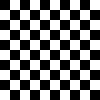

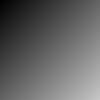

In [14]:
display(PIL.Image.fromarray(255*checker).convert("RGB"))
display(PIL.Image.fromarray(ramp).convert("RGB"))

Now, in order to hold outputs of other sizes, we need the following buffers to be setup

In [15]:
blur_out   = np.zeros([100,100], order='F')
energy_out = np.zeros([1], order='F')
grad_x_out = np.zeros([99,100], order='F')
grad_y_out = np.zeros([100,99], order='F')

We can call the pipelines and visualize results now...

INIT COMPILE


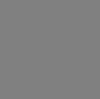

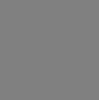

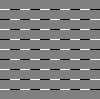

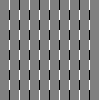

In [16]:
gradpipe.exec([],[ramp],[grad_x_out,grad_y_out])
display(PIL.Image.fromarray(128*grad_x_out).convert("RGB"))
display(PIL.Image.fromarray(128*grad_y_out).convert("RGB"))
gradpipe.exec([],[checker],[grad_x_out,grad_y_out])
display(PIL.Image.fromarray(128*grad_x_out + 128).convert("RGB"))
display(PIL.Image.fromarray(128*grad_y_out + 128).convert("RGB"))

INIT COMPILE


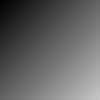

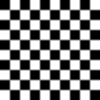

In [17]:
blurpipe.exec([100,100],[ramp],[blur_out])
display(PIL.Image.fromarray(1*blur_out).convert("RGB"))
blurpipe.exec([100,100],[checker],[blur_out])
display(PIL.Image.fromarray(256*blur_out).convert("RGB"))

In [19]:
laplacepipe.exec([100,100],[ramp],[energy_out])
print(energy_out[0])
laplacepipe.exec([100,100],[checker],[energy_out])
print(energy_out[0])

19800.0
1800.0
